In [1]:
import urllib, os, sys, zipfile
from os.path import dirname

import numpy as np

import tensorflow as tf
from tensorflow.core.framework import graph_pb2

In [2]:
from IPython.display import clear_output, Image, display, HTML
%matplotlib inline

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
with open("./mobilenet_ssd_iot2040/graph.pb", 'rb') as f:
    print("Reading model from disk...")
    serialized = f.read()

tf.reset_default_graph()
original_gdef = tf.GraphDef()
original_gdef.ParseFromString(serialized)

with tf.Graph().as_default() as g:
    print("Importing model in TF...")
    tf.import_graph_def(original_gdef, name='')

print("Done.")

Reading model from disk...
Importing model in TF...
Done.


The full MobileNet-SSD TF model contains 4 subgraphs: *Preprocessor*, *FeatureExtractor*, *MultipleGridAnchorGenerator*, and *Postprocessor*.
We'll extract and convert only *Preprocessor* because the others are not currently supported by CoreML.
The functions of the other subgraphs should be implemented by hands in iOS.

In [4]:
show_graph(original_gdef)

Strip unused subgraphs and save it as another frozen TF model

In [5]:
from tensorflow.python.tools import strip_unused_lib
from tensorflow.python.framework import dtypes
from tensorflow.python.platform import gfile

In [6]:
gdef = strip_unused_lib.strip_unused(
    input_graph_def = original_gdef,
    input_node_names = ['Preprocessor/sub'],
    output_node_names = ['concat', 'concat_1'],
    placeholder_type_enum = dtypes.float32.as_datatype_enum
)

Save the feature extractor to an output file

In [7]:
frozen_model_file = "./mobilenet_ssd_iot2040/feature_extractor.pb"
with gfile.GFile(frozen_model_file, "wb") as f:
    f.write(gdef.SerializeToString())

Now we have a TF model ready to be converted to CoreML

In [14]:
import tfcoreml

# Call the converter. This may take a while
coreml_model = tfcoreml.convert(
#     red_bias = -1, 
#     green_bias = -1, 
#     blue_bias = -1, 
#     image_scale = 2.0/255.0,
#     image_input_names = "Preprocessor/sub:0",
    
    tf_model_path         = frozen_model_file,
    mlmodel_path          = "./ssd_mobilenet_iot2040.mlmodel",
    input_name_shape_dict = {"Preprocessor/sub:0":[1,300,300,3]}, # batch size is 1,
    output_feature_names  = ['concat:0', 'concat_1:0']
)

Shapes not found for 187 tensors. Executing graph to determine shapes. 
Automatic shape interpretation succeeded for input blob Preprocessor/sub:0
9/931: Converting op name: strided_slice_14 ( type:  StridedSlice )
38/931: Converting op name: BoxPredictor_5/ClassPredictor/biases/read ( type:  Identity )
40/931: Converting op name: BoxPredictor_5/ClassPredictor/weights/read ( type:  Identity )
42/931: Converting op name: BoxPredictor_5/BoxEncodingPredictor/biases/read ( type:  Identity )
44/931: Converting op name: BoxPredictor_5/BoxEncodingPredictor/weights/read ( type:  Identity )
54/931: Converting op name: BoxPredictor_4/ClassPredictor/biases/read ( type:  Identity )
56/931: Converting op name: BoxPredictor_4/ClassPredictor/weights/read ( type:  Identity )
58/931: Converting op name: BoxPredictor_4/BoxEncodingPredictor/biases/read ( type:  Identity )
60/931: Converting op name: BoxPredictor_4/BoxEncodingPredictor/weights/read ( type:  Identity )
70/931: Converting op name: BoxPredic

383/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_9_pointwise/BatchNorm/moving_variance/read ( type:  Identity )
384/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_pointwise/BatchNorm/batchnorm/add ( type:  Add )
385/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_pointwise/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
387/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_9_pointwise/BatchNorm/moving_mean/read ( type:  Identity )
389/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_9_pointwise/BatchNorm/beta/read ( type:  Identity )
391/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_9_pointwise/BatchNorm/gamma/read ( type:  Identity )
392/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_pointwise/BatchNorm/batchnorm/mul ( type:  Mul )
393/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_pointwise/BatchNorm/batchnorm/mul_2 ( type:  M

504/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_6_depthwise/BatchNorm/batchnorm/mul ( type:  Mul )
505/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_6_depthwise/BatchNorm/batchnorm/mul_2 ( type:  Mul )
506/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_6_depthwise/BatchNorm/batchnorm/sub ( type:  Sub )
508/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_6_depthwise/depthwise_weights/read ( type:  Identity )
511/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_pointwise/BatchNorm/moving_variance/read ( type:  Identity )
512/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_pointwise/BatchNorm/batchnorm/add ( type:  Add )
513/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_pointwise/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
515/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_pointwise/BatchNorm/moving_mean/read ( 

625/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_2_depthwise/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
627/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_2_depthwise/BatchNorm/moving_mean/read ( type:  Identity )
629/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_2_depthwise/BatchNorm/beta/read ( type:  Identity )
631/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_2_depthwise/BatchNorm/gamma/read ( type:  Identity )
632/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_2_depthwise/BatchNorm/batchnorm/mul ( type:  Mul )
633/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_2_depthwise/BatchNorm/batchnorm/mul_2 ( type:  Mul )
634/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_2_depthwise/BatchNorm/batchnorm/sub ( type:  Sub )
636/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_2_depthwise/depthwise_weights/read ( type:  Identity )
639

728/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
729/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/BatchNorm/batchnorm/add_1 ( type:  Add )
730/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/Relu6 ( type:  Relu6 )
731/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/depthwise ( type:  DepthwiseConv2dNative )
732/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
733/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/add_1 ( type:  Add )
734/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/Relu6 ( type:  Relu6 )
735/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_pointwise/Conv2D ( type:  Conv2D )
736/931: C

806/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_12_pointwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
807/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_12_pointwise/BatchNorm/batchnorm/add_1 ( type:  Add )
808/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_12_pointwise/Relu6 ( type:  Relu6 )
809/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_depthwise/depthwise ( type:  DepthwiseConv2dNative )
810/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_depthwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
811/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_depthwise/BatchNorm/batchnorm/add_1 ( type:  Add )
812/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_depthwise/Relu6 ( type:  Relu6 )
813/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_pointwise/Conv2D ( type:  Conv2D )
81

902/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_5_3x3_s2_128/BatchNorm/batchnorm/mul_1 ( type:  Mul )
903/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_5_3x3_s2_128/BatchNorm/batchnorm/add_1 ( type:  Add )
904/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_5_3x3_s2_128/Relu6 ( type:  Relu6 )
905/931: Converting op name: BoxPredictor_5/Shape ( type:  Shape )
906/931: Converting op name: BoxPredictor_5/strided_slice ( type:  StridedSlice )
907/931: Converting op name: BoxPredictor_5/stack_1 ( type:  Pack )
908/931: Converting op name: BoxPredictor_5/stack ( type:  Pack )
909/931: Converting op name: BoxPredictor_5/ClassPredictor/Conv2D ( type:  Conv2D )
910/931: Converting op name: BoxPredictor_5/ClassPredictor/BiasAdd ( type:  BiasAdd )
911/931: Converting op name: BoxPredictor_5/Reshape_1 ( type:  Reshape )
912/931: Converting op name: concat_1 ( type:  ConcatV2 )
913/931: Co

Now that we have converted the model to CoreML, we can test its numerical correctness by comparing it with TensorFlow model.

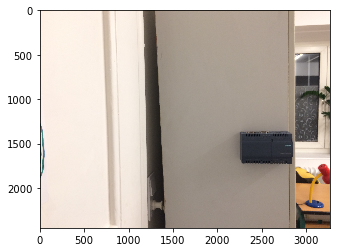

In [114]:
import PIL.Image
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
img = PIL.Image.open("mobilenet_ssd_iot2040_v1/test_image.jpg")
imshow(np.asarray(img))

In [115]:
# Preprocess the image - normalize to [-1,1]
img = img.resize([300,300], PIL.Image.ANTIALIAS)
img_array = np.array(img).astype(np.float32) * 2.0 / 255 - 1
batch_img_array = img_array[None,:,:,:]

# Evaluate TF
tf.reset_default_graph()
g = tf.import_graph_def(gdef) # gdef – stripped model

tf_input_name = 'Preprocessor/sub:0'
tf_output_names = ['concat:0', 'concat_1:0']
# concat:0 are the bounding-box encodings of the 1917 anchor boxes
# concat_1:0 are the confidence scores of 91 classes of anchor boxes
with tf.Session(graph = g) as sess:
    image_input_tensor = sess.graph.get_tensor_by_name("import/" + tf_input_name)
    tf_output_tensors = [sess.graph.get_tensor_by_name("import/" + output_name)
                             for output_name in tf_output_names]
    tf_output_values = sess.run(
        tf_output_tensors, 
        feed_dict={image_input_tensor: batch_img_array}
    )
    tf_box_encodings, tf_scores = tf_output_values

In [116]:
print(tf_box_encodings.shape, tf_scores.shape)

((1, 1917, 4), (1, 1917, 2))


In [18]:
tf_scores[0, 0, :]

array([ 6.3671155 , -6.38430071], dtype=float32)

Now we evaluate CoreML model and compare result against TensorFlow model. CoreML uses 5D arrays to represent rank-1 to rank-5 tensors. The 5 axes are in the order of (S,B,C,H,W), where S is sequence length, B is batch size, C is number of channels, H is height and W is width. This data layout is usually different from TensorFlow's default layout, where a rank-4 tensor for convolutional nets usually uses (B,H,W,C) layout. To make a comparison, one of the result should be transposed.

In [19]:
import coremltools

#  CoreML expects input shape of [1, 1, 3, 300, 300]
print("Preparing image input for CoreML...")
img_array_coreml = np.transpose(img_array, (2,0,1))[None,None,:,:,:]
print("Importing model into CoreML...")
mlmodel = coremltools.models.MLModel("./ssd_mobilenet_iot2040.mlmodel")

# Pay attention to '__0'. We change ':0' to '__0' to make sure MLModel's 
# generated Swift/Obj-C code is semantically correct
coreml_input_name = tf_input_name.replace(':', '__').replace('/', '__')
coreml_output_names = [output_name.replace(':', '__').replace('/', '__') 
                       for output_name in tf_output_names]
coreml_input = {coreml_input_name: img_array_coreml}

# When useCPUOnly == True, Relative error should be around 0.001
# When useCPUOnly == False on GPU enabled devices, relative errors 
# are expected to be larger due to utilization of lower-precision arithmetics
print("Predicting with CoreML...")
coreml_outputs_dict = mlmodel.predict(coreml_input, useCPUOnly=True)
coreml_outputs = [coreml_outputs_dict[out_name] for out_name in coreml_output_names]
coreml_box_encodings, coreml_scores = coreml_outputs
print("Done")

Preparing image input for CoreML...
Importing model into CoreML...
Predicting with CoreML...
Done


In [21]:
print(coreml_box_encodings.shape, coreml_scores.shape)
print(coreml_scores[0, 0, :, 0, 0])

((1, 1, 4, 1, 1917), (1, 1, 2, 1, 1917))
[ 6.36729908 -6.38447952]


In [22]:
# Now we compare the differences of two results
def max_relative_error(x, y):
    den = np.maximum(x, y)
    den = np.maximum(den, 1)
    rel_err = (np.abs(x-y)) / den
    return np.max(rel_err)

rel_error_box = max_relative_error(
    coreml_box_encodings.squeeze(), 
    np.transpose(tf_box_encodings.squeeze(), (1,0))
)
rel_error_score = max_relative_error(
    coreml_scores.squeeze(), 
    np.transpose(tf_scores.squeeze(),(1,0))
)

In [23]:
print('Max relative error on box encoding: %f' %(rel_error_box))
print('Max relative error on scores: %f' %(rel_error_score))

Max relative error on box encoding: 0.001790
Max relative error on scores: 0.004421


In [24]:
coreml_scores[0, 0, :, 0, 0]

array([ 6.36729908, -6.38447952])

In [81]:
coreml_scores.shape

(1, 1, 2, 1, 1917)

In [300]:
def test():
    anchors = np.transpose([[15.0, 12.0, 30.0, 18.0], [0.1, 0.0, 0.7, 0.9]])
    ymin = anchors[0, :]
    xmin = anchors[1, :]
    ymax = anchors[2, :]
    xmax = anchors[3, :]
    wa = xmax - xmin
    ha = ymax - ymin
    ycenter_a = ymin + height / 2.
    xcenter_a = xmin + width / 2.

    box_encodings = np.array([[-1., -1.25, -1.62186, -0.911608],
                              [-0.166667, -0.666667, -2.772588, -5.493062]])
    box_encodings = np.squeeze(box_encodings).transpose()
    ty, tx, th, tw = box_encodings[0, :], box_encodings[1, :], box_encodings[2, :], box_encodings[3, :]

    scale_factors = [2, 3, 4, 5]
    ty /= scale_factors[0]
    tx /= scale_factors[1]
    th /= scale_factors[2]
    tw /= scale_factors[3]

    w = np.exp(tw) * wa
    h = np.exp(th) * ha
    ycenter = ty * ha + ycenter_a
    xcenter = tx * wa + xcenter_a
    ymin = ycenter - h / 2.
    xmin = xcenter - w / 2.
    ymax = ycenter + h / 2.
    xmax = xcenter + w / 2.
    
    print(np.transpose(np.stack([ymin.round(decimals=1), xmin.round(decimals=1), ymax.round(decimals=1), xmax.round(decimals=1)])))
    # expected_boxes = [[10.0, 10.0, 20.0, 15.0], [0.2, 0.1, 0.5, 0.4]]
test()

[[ 10.   10.   20.   15. ]
 [  0.2   0.1   0.5   0.4]]


In [282]:
ycenter_a = np.loadtxt("./mobilenet_ssd_iot2040_v1/anchors_ycenter.txt", delimiter=",")
xcenter_a = np.loadtxt("./mobilenet_ssd_iot2040_v1/anchors_xcenter.txt", delimiter=",")
ha = np.loadtxt("./mobilenet_ssd_iot2040_v1/anchors_h.txt", delimiter=",")
wa = np.loadtxt("./mobilenet_ssd_iot2040_v1/anchors_w.txt", delimiter=",")

In [283]:
box_encodings = np.squeeze(coreml_box_encodings)

In [284]:
#np.squeeze(coreml_box_encodings).shape
box_encodings.shape

(4, 1917)

In [286]:
ty, tx, th, tw = box_encodings[0, :], box_encodings[1, :], box_encodings[2, :], box_encodings[3, :]

In [290]:
box_encodings

array([[  3.75328243e-05,  -5.63858032e-05,   4.26896381e-04, ...,
          1.24622595e-03,   2.51080394e-04,   2.44807482e-03],
       [ -4.24399519e-04,   8.71035576e-05,  -3.17142391e-04, ...,
         -3.01207006e-04,   2.44648065e-05,   1.97633576e-03],
       [ -3.87957611e-03,  -9.92532063e-04,   2.22048359e-03, ...,
          3.76773529e-02,  -1.86367996e-01,  -5.88421059e-02],
       [ -5.36923409e-03,  -3.40453434e-04,  -1.05149933e-02, ...,
         -1.94695129e-01,   5.74747887e-02,  -8.90907364e-02]])

In [296]:
print(box_encodings[0, :].shape)
tx.shape

(1917,)


(1917,)

In [297]:
scale_factors = [10.0, 10.0, 5.0, 5.0]
ty /= scale_factors[0]
tx /= scale_factors[1]
th /= scale_factors[2]
tw /= scale_factors[3]

In [209]:
w = np.exp(tw) * wa
h = np.exp(th) * ha
ycenter = ty * ha + ycenter_a
xcenter = tx * wa + xcenter_a
ymin = ycenter - h / 2.
xmin = xcenter - w / 2.
ymax = ycenter + h / 2.
xmax = xcenter + w / 2.

In [266]:
w.clip(0, 1) * 300

array([  29.83935508,   84.82393414,   41.98263266, ...,  300.        ,
        174.27035726,  267.48008837])

In [210]:
np.transpose(np.stack([ymin, xmin, ymax, xmax]))

array([[-0.02348685, -0.02345891,  0.07612594,  0.07600561],
       [-0.04433272, -0.11503279,  0.09694835,  0.16771365],
       [-0.1152992 , -0.04370012,  0.16817227,  0.09624199],
       ..., 
       [ 0.21591233, -0.17766795,  0.78545473,  1.1766767 ],
       [-0.18245575,  0.20956282,  1.18328207,  0.79046401],
       [ 0.04289508,  0.05612615,  0.9618771 ,  0.94772644]])

In [213]:
yscale = 1 / 300. # height
xscale = 1 / 300.

In [226]:
ymin = ymin.clip(0, 1) * 300
xmin = xmin.clip(0, 1) * 300
ymax = ymax.clip(0, 1) * 300
xmax = xmax.clip(0, 1) * 300

In [262]:
from PIL import Image, ImageDraw
# rectangles (width, height, left position, top position)
img = PIL.Image.open("mobilenet_ssd_iot2040_v1/test_image.jpg").resize([300,300], PIL.Image.ANTIALIAS)
draw = ImageDraw.Draw(img)
for i in range(669, 672):
    print([xmin[i], ymin[i], xmax[i], ymax[i]])
    draw.rectangle([xmin[i], ymin[i], xmax[i], ymax[i]], outline=(0, 255, 0, 255))

[213.78720127843783, 166.55603392996531, 244.25094617186735, 196.80058025410668]
[186.89729950051884, 160.25722543776195, 270.96739622406187, 203.04398698275341]
[207.6008092186745, 139.96311538650994, 250.44037759097046, 223.27560585824352]


In [260]:
np.squeeze(coreml_scores).transpose()[:, 1].argmax()

670

In [252]:
np.squeeze(coreml_scores)[:, 1]

array([ 9.763834  , -9.81798077])

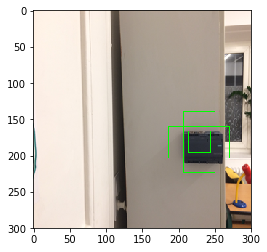

In [263]:
imshow(img)

In [128]:
np.concatenate([np.array([19] * 2), np.array([10] * 2)])

array([19, 19, 10, 10])

In [108]:
img_width = test_img.shape[1]
img_height = test_img.shape[0]
scaleX = img_width / 300.0
scaleY = img_height / 300.0
top = (view.bounds.height - height) / 2

// Translate and scale the rectangle to our own coordinate system.
var rect = prediction.rect
rect.origin.x *= scaleX
rect.origin.y *= scaleY
rect.origin.y += top
rect.size.width *= scaleX
rect.size.height *= scaleY

1.4268821539885415

In [35]:
def _decode(self, rel_codes, anchors):
    """Decode relative codes to boxes.
    Args:
      rel_codes: a tensor representing N anchor-encoded boxes.
      anchors: BoxList of anchors.
    Returns:
      boxes: BoxList holding N bounding boxes.
    """
    ycenter_a, xcenter_a, ha, wa = anchors.get_center_coordinates_and_sizes()

    ty, tx, th, tw = tf.unstack(tf.transpose(rel_codes))
    if self._scale_factors:
      ty /= self._scale_factors[0]
      tx /= self._scale_factors[1]
      th /= self._scale_factors[2]
      tw /= self._scale_factors[3]
    w = tf.exp(tw) * wa
    h = tf.exp(th) * ha
    ycenter = ty * ha + ycenter_a
    xcenter = tx * wa + xcenter_a
    ymin = ycenter - h / 2.
    xmin = xcenter - w / 2.
    ymax = ycenter + h / 2.
    xmax = xcenter + w / 2.
    return box_list.BoxList(tf.transpose(tf.stack([ymin, xmin, ymax, xmax])))

0.026315789669752121

In [26]:
# Call the converter. This may take a while
coreml_model = tfcoreml.convert(
    red_bias = -1, 
    green_bias = -1, 
    blue_bias = -1, 
    image_scale = 2.0/255.0,
    image_input_names = "Preprocessor/sub:0",
    
    tf_model_path         = frozen_model_file,
    mlmodel_path          = "./ssd_mobilenet_iot2040.mlmodel",
    input_name_shape_dict = {"Preprocessor/sub:0":[1,300,300,3]}, # batch size is 1,
    output_feature_names  = ['concat:0', 'concat_1:0']
)

Shapes not found for 187 tensors. Executing graph to determine shapes. 
Automatic shape interpretation succeeded for input blob Preprocessor/sub:0
9/931: Converting op name: strided_slice_14 ( type:  StridedSlice )
38/931: Converting op name: BoxPredictor_5/ClassPredictor/biases/read ( type:  Identity )
40/931: Converting op name: BoxPredictor_5/ClassPredictor/weights/read ( type:  Identity )
42/931: Converting op name: BoxPredictor_5/BoxEncodingPredictor/biases/read ( type:  Identity )
44/931: Converting op name: BoxPredictor_5/BoxEncodingPredictor/weights/read ( type:  Identity )
54/931: Converting op name: BoxPredictor_4/ClassPredictor/biases/read ( type:  Identity )
56/931: Converting op name: BoxPredictor_4/ClassPredictor/weights/read ( type:  Identity )
58/931: Converting op name: BoxPredictor_4/BoxEncodingPredictor/biases/read ( type:  Identity )
60/931: Converting op name: BoxPredictor_4/BoxEncodingPredictor/weights/read ( type:  Identity )
70/931: Converting op name: BoxPredic

369/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
371/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_10_depthwise/BatchNorm/moving_mean/read ( type:  Identity )
373/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_10_depthwise/BatchNorm/beta/read ( type:  Identity )
375/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_10_depthwise/BatchNorm/gamma/read ( type:  Identity )
376/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/BatchNorm/batchnorm/mul ( type:  Mul )
377/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/BatchNorm/batchnorm/mul_2 ( type:  Mul )
378/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/BatchNorm/batchnorm/sub ( type:  Sub )
380/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_10_depthwise/depthwise_weights/read ( type:  Identi

524/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_pointwise/weights/read ( type:  Identity )
527/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_depthwise/BatchNorm/moving_variance/read ( type:  Identity )
528/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/add ( type:  Add )
529/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
531/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_depthwise/BatchNorm/moving_mean/read ( type:  Identity )
533/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_depthwise/BatchNorm/beta/read ( type:  Identity )
535/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_5_depthwise/BatchNorm/gamma/read ( type:  Identity )
536/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/mul ( type:  Mul )
537/931: Conver

672/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/add ( type:  Add )
673/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
675/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_0/BatchNorm/moving_mean/read ( type:  Identity )
677/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_0/BatchNorm/beta/read ( type:  Identity )
679/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_0/BatchNorm/gamma/read ( type:  Identity )
680/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/mul ( type:  Mul )
681/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/mul_2 ( type:  Mul )
682/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/sub ( type:  Sub )
684/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_0/weights/

760/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_8_pointwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
761/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_8_pointwise/BatchNorm/batchnorm/add_1 ( type:  Add )
762/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_8_pointwise/Relu6 ( type:  Relu6 )
763/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_depthwise/depthwise ( type:  DepthwiseConv2dNative )
764/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_depthwise/BatchNorm/batchnorm/mul_1 ( type:  Mul )
765/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_depthwise/BatchNorm/batchnorm/add_1 ( type:  Add )
766/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_depthwise/Relu6 ( type:  Relu6 )
767/931: Converting op name: FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_9_pointwise/Conv2D ( type:  Conv2D )
768/931: C

854/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_1_Conv2d_3_1x1_128/BatchNorm/batchnorm/mul_1 ( type:  Mul )
855/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_1_Conv2d_3_1x1_128/BatchNorm/batchnorm/add_1 ( type:  Add )
856/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_1_Conv2d_3_1x1_128/Relu6 ( type:  Relu6 )
857/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/Conv2D ( type:  Conv2D )
858/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/BatchNorm/batchnorm/mul_1 ( type:  Mul )
859/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/BatchNorm/batchnorm/add_1 ( type:  Add )
860/931: Converting op name: FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/Relu6 ( type:  Relu6 )
861/931: Converting op name: BoxPredictor_3/Shape ( type:  Shape )
862/931

In [31]:
import coremltools
import sys, os
import operator

spec = coremltools.utils.load_spec("./ssd_mobilenet_iot2040.mlmodel")
shape_dict = _infer_shapes("./ssd_mobilenet_iot2040.mlmodel")

types_dict = {}

nn = spec.neuralNetwork
if spec.WhichOneof('Type') == 'neuralNetwork':
    nn = spec.neuralNetwork
elif spec.WhichOneof('Type') == 'neuralNetworkRegressor':
    nn = spec.neuralNetworkRegressor
elif spec.WhichOneof('Type') == 'neuralNetworkClassifier':
    nn = spec.neuralNetworkClassifier
else:
    raise ValueError("Only neural network model Type is supported")

for i, layer in enumerate(nn.layers):
    print('---------------------------------------------------------------------------------------------------------------------------------------------')
    print("{}: layer name = {}, layer type = ( {} ), \n inputs = \n {}, \n input shapes = {}, \n outputs = \n {}, \n output shapes = {} ".format(i, layer.name, \
            layer.WhichOneof('layer'), ", ".join([x for x in layer.input]), ", ".join([str(shape_dict[x]) for x in layer.input]),
            ", ".join([x for x in layer.output]),
            ", ".join([str(shape_dict[x]) for x in layer.output])))


    layer_type = layer.WhichOneof('layer')
    if layer_type in types_dict:
        types_dict[layer_type] += 1
    else:
        types_dict[layer_type] = 1

print('---------------------------------------------------------------------------------------------------------------------------------------------')
sorted_types_count = sorted(types_dict.items(), key=operator.itemgetter(1))
print('Layer Type counts:')
for i in sorted_types_count:
    print("{} : {}".format(i[0], i[1]))


Loading spec. This might take a while.....
Spec loaded. Time taken = 23.225935 secs
Input shape(s) :
Preprocessor__sub__0 ---> (1, 1, 3, 300, 300)
1/262: Calling Layer of type convolution
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/Conv2D:0 ----> (1, 1, 32, 150, 150)
2/262: Calling Layer of type batchnorm
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/BatchNorm/batchnorm/add_1:0 ----> (1, 1, 32, 150, 150)
3/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/Relu6:0 ----> (1, 1, 32, 150, 150)
4/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/Relu6:0_neg ----> (1, 1, 32, 150, 150)
5/262: Calling Layer of type unary
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/Relu6:0_clip ----> (1, 1, 32, 150, 150)
6/262: Calling Layer of type activation
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2

Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/Relu6:0_neg ----> (1, 1, 256, 38, 38)
53/262: Calling Layer of type unary
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/Relu6:0_clip ----> (1, 1, 256, 38, 38)
54/262: Calling Layer of type activation
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/Relu6:0 ----> (1, 1, 256, 38, 38)
55/262: Calling Layer of type convolution
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/depthwise:0 ----> (1, 1, 256, 38, 38)
56/262: Calling Layer of type batchnorm
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/BatchNorm/batchnorm/add_1:0 ----> (1, 1, 256, 38, 38)
57/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/Relu6:0 ----> (1, 1, 256, 38, 38)
58/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/Mobile

Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/Relu6:0_clip ----> (1, 1, 512, 19, 19)
120/262: Calling Layer of type activation
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_depthwise/Relu6:0 ----> (1, 1, 512, 19, 19)
121/262: Calling Layer of type convolution
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Conv2D:0 ----> (1, 1, 512, 19, 19)
122/262: Calling Layer of type batchnorm
Output shape(s):
FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_pointwise/BatchNorm/batchnorm/add_1:0 ----> (1, 1, 512, 19, 19)
123/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Relu6:0 ----> (1, 1, 512, 19, 19)
124/262: Calling Layer of type activation
Output shape(s):
relu_FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Relu6:0_neg ----> (1, 1, 512, 19, 19)
125/262: Calling Layer of type unary
Output shape(s):
relu_FeatureExtract

Output shape(s):
FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_2_3x3_s2_512/Relu6:0 ----> (1, 1, 512, 5, 5)
187/262: Calling Layer of type convolution
Output shape(s):
BoxPredictor_2/ClassPredictor/Conv2D:0 ----> (1, 1, 12, 5, 5)
188/262: Calling Layer of type batchnorm
Output shape(s):
BoxPredictor_2/ClassPredictor/BiasAdd:0 ----> (1, 1, 12, 5, 5)
189/262: Calling Layer of type reshape
Output shape(s):
BoxPredictor_2/Reshape_1:0 ----> (1, 1, 2, 1, 150)
190/262: Calling Layer of type convolution
Output shape(s):
BoxPredictor_2/BoxEncodingPredictor/Conv2D:0 ----> (1, 1, 24, 5, 5)
191/262: Calling Layer of type batchnorm
Output shape(s):
BoxPredictor_2/BoxEncodingPredictor/BiasAdd:0 ----> (1, 1, 24, 5, 5)
192/262: Calling Layer of type reshape
Output shape(s):
BoxPredictor_2/Reshape:0 ----> (1, 1, 4, 1, 150)
193/262: Calling Layer of type convolution
Output shape(s):
FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_1_Conv2d_3_1x1_128/Conv2D:0 ----> (1, 1, 128, 5, 5)
194/262: 

Output shape(s):
Squeeze_1:0_swap_W_C_1 ----> (1, 1, 600, 1, 4)
257/262: Calling Layer of type permute
Output shape(s):
Squeeze_2:0_swap_W_C_2 ----> (1, 1, 150, 1, 4)
258/262: Calling Layer of type permute
Output shape(s):
Squeeze_3:0_swap_W_C_3 ----> (1, 1, 54, 1, 4)
259/262: Calling Layer of type permute
Output shape(s):
Squeeze_4:0_swap_W_C_4 ----> (1, 1, 24, 1, 4)
260/262: Calling Layer of type permute
Output shape(s):
Squeeze_5:0_swap_W_C_5 ----> (1, 1, 6, 1, 4)
261/262: Calling Layer of type concat
Output shape(s):
concat:0_concat ----> (1, 1, 1917, 1, 4)
262/262: Calling Layer of type permute
Output shape(s):
concat__0 ----> (1, 1, 4, 1, 1917)
---------------------------------------------------------------------------------------------------------------------------------------------
0: layer name = FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/Conv2D:0, layer type = ( convolution ), 
 inputs = 
 Preprocessor__sub__0, 
 input shapes = (1, 1, 3, 300, 300), 
 outputs = 
 Featur

In [29]:
import math
import numpy as np
import coremltools
from coremltools.proto import FeatureTypes_pb2 as _FeatureTypes_pb2
from coremltools.proto import NeuralNetwork_pb2 as _NeuralNetwork_pb2
import sys
import time

_LAYER_REGISTRY = dict()

def _get_translator_function(layer_type):
    """Get the right translator function
    """
    if layer_type in _LAYER_REGISTRY:
        return _LAYER_REGISTRY[layer_type]
    else:
        raise TypeError("Shape computation function missing for layer of type %s." % type(layer_type))

def _identity(layer, shape_dict):
    shape_dict[layer.output[0]] = shape_dict[layer.input[0]]

def _convolution(layer, shape_dict):
    params = layer.convolution
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    n_groups = params.nGroups
    Kh = Kw = 3
    hstride = wstride = hdilation = wdilation = 1
    if len(params.kernelSize) != 0:
        Kh, Kw = params.kernelSize
    if len(params.stride) != 0:
        hstride, wstride = params.stride
    if len(params.dilationFactor) != 0:
        hdilation, wdilation = params.dilationFactor
    Kh_dilated = (Kh-1) * hdilation + 1
    Kw_dilated = (Kw-1) * wdilation + 1
    l = r = b = t = 0
    if params.WhichOneof('ConvolutionPaddingType') == 'valid':
        if len(params.valid.paddingAmounts.borderAmounts) != 0:
            t = params.valid.paddingAmounts.borderAmounts[0].startEdgeSize
            b = params.valid.paddingAmounts.borderAmounts[0].endEdgeSize
            l = params.valid.paddingAmounts.borderAmounts[1].startEdgeSize
            r = params.valid.paddingAmounts.borderAmounts[1].endEdgeSize
        if params.isDeconvolution:
            Hout = (Hin -1) * hstride + Kh_dilated - t - b
            Wout = (Win -1) * wstride + Kw_dilated - r - l
        else:
            Hout = (Hin + t + b - Kh_dilated)/hstride + 1
            Wout = (Win + r + l - Kw_dilated)/wstride + 1
    else:
        if params.isDeconvolution:
            Hout = Hin * hstride
            Wout = Win * wstride
        else:
            Hout = math.ceil(Hin/float(hstride))
            Wout = math.ceil(Win/float(wstride))

    if params.isDeconvolution:
        if len(params.outputShape) != 0:
            Hout, Wout = params.outputShape

    Cout = params.outputChannels
    shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), int(Hout), int(Wout))

def _pooling(layer, shape_dict):
    params = layer.pooling
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    Kh = Kw = 3
    hstride = wstride = 1
    if len(params.kernelSize) != 0:
        Kh, Kw = params.kernelSize
    if len(params.stride) != 0:
        hstride, wstride = params.stride
    l = r = b = t = 0
    if params.globalPooling:
        Hout = Wout = 1
    else:
        if params.WhichOneof('PoolingPaddingType') == 'valid':
            if len(params.valid.paddingAmounts.borderAmounts) != 0:
                t = params.valid.paddingAmounts.borderAmounts[0].startEdgeSize
                b = params.valid.paddingAmounts.borderAmounts[0].endEdgeSize
                l = params.valid.paddingAmounts.borderAmounts[1].startEdgeSize
                r = params.valid.paddingAmounts.borderAmounts[1].endEdgeSize
            Hout = (Hin + t + b - Kh)/hstride + 1
            Wout = (Win + r + l - Kw)/wstride + 1
        elif params.WhichOneof('PoolingPaddingType') == 'same':
            Hout = math.ceil(Hin/float(hstride))
            Wout = math.ceil(Win/float(wstride))
        else:
            if len(params.includeLastPixel.paddingAmounts) != 0:
                t = params.includeLastPixel.paddingAmounts[0]
                b = t
                l = params.includeLastPixel.paddingAmounts[1]
                r = l
            Hout = math.ceil((Hin + 2*t - Kh)/float(hstride)) + 1
            Wout = math.ceil((Win + 2*l - Kw)/float(wstride)) + 1
            if t or l:
                if (Hout-1) * hstride >= Hin + t:
                    Hout -= 1
                if (Wout-1) * wstride >= Win + l:
                    Wout -= 1

    shape_dict[layer.output[0]] = (Seq, Batch, int(Cin), int(Hout), int(Wout))

def _inner_product(layer, shape_dict):
    params = layer.innerProduct
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]
    Cout = params.outputChannels
    shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), 1, 1)

def _embedding(layer, shape_dict):
    params = layer.embedding
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]
    Cout = params.outputChannels
    shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), 1, 1)

def _crop(layer, shape_dict):
    params = layer.crop
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    l = r = t = b = 0
    if len(layer.input) == 1:
        if len(params.cropAmounts.borderAmounts) != 0:
            t = params.cropAmounts.borderAmounts[0].startEdgeSize
            b = params.cropAmounts.borderAmounts[0].endEdgeSize
            l = params.cropAmounts.borderAmounts[1].startEdgeSize
            r = params.cropAmounts.borderAmounts[1].endEdgeSize
        Hout = Hin - t - b
        Wout = Win - l - r
    else:
        Hout = shape_dict[layer.input[1]][3]
        Wout = shape_dict[layer.input[1]][4]

    shape_dict[layer.output[0]] = (Seq, Batch, Cin, int(Hout), int(Wout))

def _padding(layer, shape_dict):
    params = layer.padding
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    l = r = t = b = 0
    if len(params.paddingAmounts.borderAmounts) != 0:
        t = params.paddingAmounts.borderAmounts[0].startEdgeSize
        b = params.paddingAmounts.borderAmounts[0].endEdgeSize
        l = params.paddingAmounts.borderAmounts[1].startEdgeSize
        r = params.paddingAmounts.borderAmounts[1].endEdgeSize
    Hout = Hin + t + b
    Wout = Win + l + r
    shape_dict[layer.output[0]] = (Seq, Batch, Cin, int(Hout), int(Wout))

def _upsample(layer, shape_dict):
    params = layer.upsample
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    sh = sw = 1
    if len(params.scalingFactor) != 0:
        sh, sw = params.scalingFactor
    Hout = Hin * sh
    Wout = Win * sw
    shape_dict[layer.output[0]] = (Seq, Batch, Cin, int(Hout), int(Wout))

def _add(layer, shape_dict):
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]

    for i, inp in enumerate(layer.input):
        if i==0:
            continue
        _, _, c, h, w = shape_dict[inp]
        C = max(C, c)
        H = max(H, h)
        W = max(W, w)
    shape_dict[layer.output[0]] = (Seq, Batch, int(C), int(H), int(W))

def _dot(layer, shape_dict):
    Seq, Batch, _, _, _ = shape_dict[layer.input[0]]
    shape_dict[layer.output[0]] = (Seq, Batch, 1, 1, 1)

def _reduce(layer, shape_dict):
    params = layer.reduce
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]

    axis = _NeuralNetwork_pb2.ReduceLayerParams.ReduceAxis.Name(params.axis)
    if axis == 'CHW':
        C = H = W = 1
    elif axis == 'HW':
        H = W = 1
    elif axis == 'C':
        C = 1
    elif axis == 'H':
        H = 1
    elif axis == 'W':
        W = 1

    shape_dict[layer.output[0]] = (Seq, Batch, int(C), int(H), int(W))

def _load_constant(layer, shape_dict):
    params = layer.loadConstant
    C, H, W = map(int, params.shape)
    shape_dict[layer.output[0]] = (1, 1, C, H, W)

def _reshape(layer, shape_dict):
    params = layer.reshape
    Seq, Batch, _, _, _ = shape_dict[layer.input[0]]

    if len(params.targetShape) == 3:
        C, H, W = params.targetShape
    else:
        Seq, C, H, W = params.targetShape

    shape_dict[layer.output[0]] = (int(Seq), Batch, int(C), int(H), int(W))

def _permute(layer, shape_dict):
    params = layer.permute
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]

    axis = map(int, params.axis)
    dims = (Seq, Cin, Hin, Win)
    Seq_out = dims[axis[0]]
    Cout = dims[axis[1]]
    Hout = dims[axis[2]]
    Wout = dims[axis[3]]
    shape_dict[layer.output[0]] = (int(Seq_out), Batch, int(Cout), int(Hout), int(Wout))

def _concat(layer, shape_dict):
    params = layer.concat
    Seq, Batch, C , H, W = shape_dict[layer.input[0]]

    if params.sequenceConcat:
        Seq = 0
        for inp in layer.input:
            Seq += shape_dict[inp][0]
    else:
        C = 0
        for inp in layer.input:
            C += shape_dict[inp][2]

    shape_dict[layer.output[0]] = (int(Seq), Batch, int(C), int(H), int(W))

def _split(layer, shape_dict):
    input_shape = shape_dict[layer.input[0]]
    Seq, Batch, C, H, W = input_shape
    for out in layer.output:
        shape_dict[out] = (Seq, Batch, C / len(layer.output), H, W)

def _sequence_repeat(layer, shape_dict):
    params = layer.sequenceRepeat
    n = params.nRepetitions
    if n == 0: n = 1
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]
    shape_dict[layer.output[0]] = (int(Seq * n), Batch, C, H, W)

def _reorganize_data(layer, shape_dict):
    params = layer.reorganizeData
    Seq, Batch, Cin, Hin, Win = shape_dict[layer.input[0]]
    block_size = params.blockSize
    Type = _NeuralNetwork_pb2.ReorganizeDataLayerParams.ReorganizationType.Name(params.mode)
    if Type == 'SPACE_TO_DEPTH':
        Cout = Cin * block_size * block_size
        Hout = Hin / block_size
        Wout = Win / block_size
    else:
        Cout = Cin / (block_size * block_size)
        Hout = Hin * block_size
        Wout = Win * block_size
    shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), int(Hout), int(Wout))

def _slice(layer, shape_dict):
    params = layer.slice
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]
    start = params.startIndex
    end = params.endIndex
    stride = params.stride
    axis = _NeuralNetwork_pb2.SliceLayerParams.SliceAxis.Name(params.axis)
    if axis == 'CHANNEL_AXIS': N = C
    if axis == 'HEIGHT_AXIS': N = H
    if axis == 'WIDTH_AXIS': N = W
    if end < 0: end = end + N
    end = min(end, N)
    if start > N-1:
        L = 0
    else:
        L = np.floor((end - 1 - start)/stride) + 1
        if L<0 : L = 0
    if axis == 'CHANNEL_AXIS': C = L
    if axis == 'HEIGHT_AXIS': H = L
    if axis == 'WIDTH_AXIS': W = L
    shape_dict[layer.output[0]] = (Seq, Batch, int(C), int(H), int(W))

def _simple_recurrent(layer, shape_dict):
    params = layer.simpleRecurrent
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]

    Cout = params.outputVectorSize
    if params.sequenceOutput:
        shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), 1, 1)
    else:
        shape_dict[layer.output[0]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[1]] = (1, Batch, int(Cout), 1, 1)

def _gru(layer, shape_dict):
    params = layer.gru
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]

    Cout = params.outputVectorSize
    if params.sequenceOutput:
        shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), 1, 1)
    else:
        shape_dict[layer.output[0]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[1]] = (1, Batch, int(Cout), 1, 1)

def _uni_directional_lstm(layer, shape_dict):
    params = layer.uniDirectionalLSTM
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]

    Cout = params.outputVectorSize
    if params.params.sequenceOutput:
        shape_dict[layer.output[0]] = (Seq, Batch, int(Cout), 1, 1)
    else:
        shape_dict[layer.output[0]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[1]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[2]] = (1, Batch, int(Cout), 1, 1)

def _bi_directional_lstm(layer, shape_dict):
    params = layer.biDirectionalLSTM
    Seq, Batch, C, H, W = shape_dict[layer.input[0]]
    Cout = params.outputVectorSize
    if params.params.sequenceOutput:
        shape_dict[layer.output[0]] = (Seq, Batch, 2 * int(Cout), 1, 1)
    else:
        shape_dict[layer.output[0]] = (1, Batch, 2 * int(Cout), 1, 1)
    shape_dict[layer.output[1]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[2]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[3]] = (1, Batch, int(Cout), 1, 1)
    shape_dict[layer.output[4]] = (1, Batch, int(Cout), 1, 1)


_LAYER_REGISTRY = {
    'convolution': _convolution,
    'pooling': _pooling,
    'activation': _identity,
    'innerProduct': _inner_product,
    'embedding': _embedding,
    'batchnorm': _identity,
    'mvn': _identity,
    'l2normalize': _identity,
    'softmax': _identity,
    'lrn': _identity,
    'crop': _crop,
    'padding': _padding,
    'upsample': _upsample,
    'unary': _identity,
    'add': _add,
    'multiply': _add,
    'average': _add,
    'scale': _add,
    'bias': _add,
    'max': _add,
    'min': _add,
    'dot': _dot,
    'reduce': _reduce,
    'loadConstant': _load_constant,
    'reshape': _reshape,
    'flatten': _dot,
    'permute': _permute,
    'concat': _concat,
    'split': _split,
    'sequenceRepeat': _sequence_repeat,
    'reorganizeData': _reorganize_data,
    'slice': _slice,
    'simpleRecurrent': _simple_recurrent,
    'gru': _gru,
    'uniDirectionalLSTM': _uni_directional_lstm,
    'biDirectionalLSTM': _bi_directional_lstm
}

def _infer_shapes(model_path, input_shape_dict = None):

    """
    Input:
        path : path to the mlmodel
        input_shape_dict: dictionary of  string --> tuple
                      string:  input name
                      tuple: input shape as a 5 length tuple in order (Seq, Batch, C, H, W)
        If input_shape_dict is not provided, input shapes are inferred from the input description in the mlmodel.
        Since the description in the specification only contains values of C,H,W; Seq and Batch dimensions are set to 1.
    Output:
        shape_dict:  dictionary containing all the blobs in the neural network and their shapes, expressed as length 5 tuples,
                     to be interpreted in order (Seq, Batch, C, H, W).
    """
    #Load the spec
    print('Loading spec. This might take a while.....')
    t = time.time()
    spec = coremltools.utils.load_spec(model_path)
    print('Spec loaded. Time taken = %f secs' % (time.time() - t))

    shape_dict = {}
    if input_shape_dict:
        for key, value in input_shape_dict.items():
            assert len(value) == 5, 'Shape of the input must be of length 5'
            shape_dict[key] = value

    # construct input_shape_dict from the model description
    else:
        for inp in spec.description.input:
            input_name = inp.name
            C = H = W = 1
            if inp.type.WhichOneof('Type') == 'imageType':
                W = int(inp.type.imageType.width)
                H = int(inp.type.imageType.height)
                colorspace = _FeatureTypes_pb2.ImageFeatureType.ColorSpace.Name(inp.type.imageType.colorSpace)
                if colorspace == 'GRAYSCALE':
                    C = 1
                elif colorspace == 'RGB' or colorspace == 'BGR':
                    C = 3
                else:
                    raise ValueError('Input %s : Invalid Colorspace' %(input_name))
            elif inp.type.WhichOneof('Type') == 'multiArrayType':
                array_shape = inp.type.multiArrayType.shape
                if len(array_shape) == 1:
                    C = array_shape[0]
                elif len(array_shape) == 3:
                    C, H, W = map(int, array_shape)
                else:
                    raise ValueError("Input %s : Multi array must be of length 1 or 3" %(input_name))
            else:
                raise ValueError("Input %s : Input type must be image or multi-array" %(input_name))
            shape_dict[input_name] = (1, 1, C, H, W)

    #now we loop through the layers
    if spec.WhichOneof('Type') == 'neuralNetwork':
        layers = spec.neuralNetwork.layers
    elif spec.WhichOneof('Type') == 'neuralNetworkRegressor':
        layers = spec.neuralNetworkRegressor.layers
    elif spec.WhichOneof('Type') == 'neuralNetworkClassifier':
        layers = spec.neuralNetworkClassifier.layers
    else:
        raise ValueError("Only neural network model Type is supported")

    print('Input shape(s) :')
    for key, value in shape_dict.items():
        print key, '--->',  value
    time.sleep(3)

    for i, layer in enumerate(layers):
        for inp in layer.input:
            assert inp in shape_dict, ('Input %s shape not cannot be determined' %(inp))
        layer_type = layer.WhichOneof('layer')
        print('%d/%d: Calling Layer of type %s' %(i+1, len(layers), layer_type))
        time.sleep(.01)
        fun = _get_translator_function(layer_type)
        fun(layer, shape_dict)

        print('Output shape(s):')
        for out in layer.output:
            print out, '---->', shape_dict[out]

    return shape_dict